In [39]:
import pandas as pd

# 날짜 컬럼 방지
def read_csv_auto_dates(path):
    # 1) 전체 파일을 먼저 읽기
    temp = pd.read_csv(path, low_memory=False)
    
    # 2) _at 로 끝나는 컬럼 자동 탐지
    date_cols = [col for col in temp.columns if col.endswith('_at')]
    
    # 3) 다시 날짜 컬럼을 datetime 으로 읽기
    return pd.read_csv(path, parse_dates=date_cols, low_memory=False)

# Load Files (전처리)
acq = read_csv_auto_dates("./clean_data_v1/clean_acquisitions_final.csv")
deg = read_csv_auto_dates("./clean_data_v1/clean_degrees_final.csv")
frs = read_csv_auto_dates("./clean_data_v1/clean_fr_final.csv")
fds = read_csv_auto_dates("./clean_data_v1/clean_funds_final.csv")
inv = read_csv_auto_dates("./clean_data_v1/clean_investments_final.csv")
ipo = read_csv_auto_dates("./clean_data_v1/clean_ipos_final.csv")
mil = read_csv_auto_dates("./clean_data_v1/clean_milestones_final.csv")
obj = read_csv_auto_dates("./clean_data_v1/clean_objects_final.csv")
peo = read_csv_auto_dates("./clean_data_v1/clean_people_final.csv")
off = read_csv_auto_dates("./clean_data_v1/clean_offices_final.csv")
rel = read_csv_auto_dates("./clean_data_v1/clean_relationships_final.csv")

# Load Files (작업용 전처리)
company = read_csv_auto_dates("./entity_type/objects_company.csv")
finorg = read_csv_auto_dates("./entity_type/objects_finorg.csv")
person = read_csv_auto_dates("./entity_type/objects_person.csv")
product = read_csv_auto_dates("./entity_type/objects_product.csv")

# statistic join load
startup_profile = read_csv_auto_dates("./statistic_join/cy_startup_profile.csv")
founder_master = read_csv_auto_dates("./statistic_join/cy_founder_master.csv")

print("="*60)
print("Dataset 로드 완료!")
print("="*60)

Dataset 로드 완료!


# 가설 검정 1: 포아송 회귀

### [창업자의 특성] → 투자 건수 

3-2) vc의 투자 의사결정은 창업자의 특징에 따라 유의미한 영향을 미친다. 

(변수: 학위, 전공, 학교, 라운드별 관계수 변화량→ 중앙값)

⭐ 종속변수 (Count): founder_vc_invest_cnt (창업자 기준 VC 투자 건수)

🌱 설명변수(x): 

    - 학위 레벨 (degree_level)

    - 전공 (subject)

    - 학교 (institution)
    
    - 창업 경험 수 (n_founding)

    - 출생지 (birthplace)

    - 관계 수 founder_round_relationship_change_median

In [40]:
founder_master

,rel_p_id,rel_cf_id,n_founding,is_past,sequence,birthplace,degree_level,subject,institution,graduated_at,founder_round_relationship_change_median,founder_vc_invest_cnt
0,p:10,c:5,1,0,1,NaN,NaN,Computer Science / Software,harvard university,NaN,134,20
1,p:100017,c:81564,1,0,1,NaN,NaN,NaN,NaN,NaN,0,11
2,p:100025,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN,10,2
3,p:100026,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN,10,2
4,p:100048,c:79332,1,0,1,NaN,NaN,NaN,NaN,NaN,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...
14742,p:9997,c:2726,1,0,1,NaN,NaN,NaN,NaN,NaN,2,18
14743,p:99977,c:81526,1,0,8,NaN,3.0,Computer Science / Software,massachusetts institute of technology (mit),NaN,2,2
14744,p:99979,c:81538,4,0,4,NaN,4.0,Arts / Humanities,NaN,NaN,1,2
14745,p:99980,c:81538,4,0,4,NaN,NaN,NaN,NaN,NaN,1,2


In [41]:
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta


# 한글 안깨지게 맥북용
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

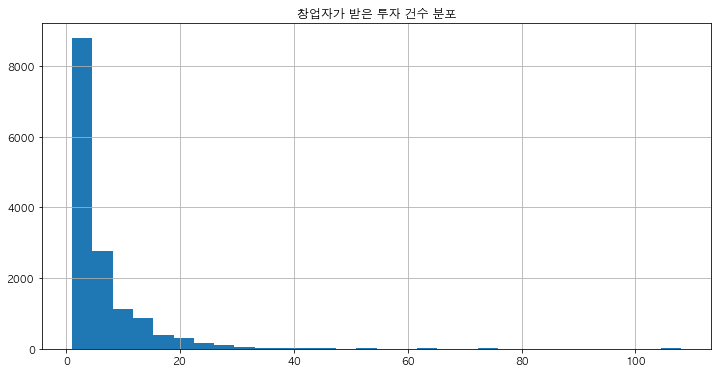

In [42]:
# 종속 변수 분포 확인

founder_master['founder_vc_invest_cnt'].hist(bins=30)
plt.title("창업자가 받은 투자 건수 분포")
plt.show()


In [43]:
founder_master['founder_vc_invest_cnt'].describe()

count    14747.000000
mean         5.863769
std          7.662429
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max        108.000000
Name: founder_vc_invest_cnt, dtype: float64

### Poisson vs Negative Binomial 판단 기준

| 상황          | 선택                               |
| ----------- | -------------------------------- |
| 평균 ≈ 분산     | Poisson                          |
| **분산 ≫ 평균** | ✅ **Negative Binomial (NB)**     |
| 0이 유독 많음    | NB 또는 Zero-inflated (여기선 NB로 충분) |


### 연속형 변수만 VIF 확인

NB는 비선형(GLM) 모델

VIF는 선형회귀 기반 지표

더미변수 많을수록 VIF는 구조적으로 커짐

In [44]:
founder_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14747 entries, 0 to 14746
Data columns (total 12 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rel_p_id                                  14747 non-null  object 
 1   rel_cf_id                                 14747 non-null  object 
 2   n_founding                                14747 non-null  int64  
 3   is_past                                   14747 non-null  int64  
 4   sequence                                  14747 non-null  int64  
 5   birthplace                                1886 non-null   object 
 6   degree_level                              6093 non-null   float64
 7   subject                                   5147 non-null   object 
 8   institution                               6542 non-null   object 
 9   graduated_at                              4395 non-null   object 
 10  founder_round_relationship_change_

In [45]:
# 연속형 변수만 VIF 확인
use_cols = [
    'n_founding', 'is_past', 'degree_level', 
    'founder_round_relationship_change_median',
    'founder_vc_invest_cnt'
]
df= founder_master[use_cols].copy()

In [46]:
# vif 다중공선성 확인

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 종속변수 제외
X = df.drop(columns=['founder_vc_invest_cnt']).copy()

# 형변환
X = X.astype(float)

# X를 “무조건 숫자”로 강제
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# 상수항 추가
X = sm.add_constant(X)

# VIF 계산
vif_df = pd.DataFrame()
vif_df["variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                                   variable       VIF
0                                     const  2.977455
1                                n_founding  1.054474
2                                   is_past  1.044080
3                              degree_level  1.042375
4  founder_round_relationship_change_median  1.015999


In [47]:
founder_master['institution'].unique()

array(['harvard university', nan, 'notre dame university', ...,
       'technology, vienna university', 'anna university',
       'united states military academy at west point'],
      shape=(1522,), dtype=object)

In [48]:
# 범주형 변수 
dum_cols = [
    'birthplace', 'subject', 'institution',
    'n_founding', 'degree_level', 
    'founder_round_relationship_change_median',
    'founder_vc_invest_cnt'
]
df= founder_master[dum_cols].copy()

# 상위 N개만 더미로 줄이기 (birthplace, institution)
def process_top_n(s, n=10, other="Other", missing="Missing"):
    # 1. 결측치 처리 및 상위 n개 추출
    s = s.fillna(missing)
    top_n_idx = s[s != missing].value_counts().head(n).index
    
    # 2. Top-n 및 Missing 외에는 Other로 변경
    s = s.where(s.isin(top_n_idx) | (s == missing), other)
    
    # 3. Categorical 변환 (Other를 가장 먼저 배치하여 drop_first 시 기준이 되게 함)
    # 실제 존재하는 값들 중 Other와 Missing을 제외한 나머지 정렬
    remains = sorted([x for x in s.unique() if x not in [other, missing]])
    categories = [other, missing] + remains
    
    return pd.Categorical(s, categories=categories, ordered=True)

###########################################################################################
# 상위 N개만 더미로 줄이기 (subject)
def process_top_n_subject(s, n=10, other_existing="Others / Unknown", missing="Missing"):
    s = s.fillna(missing)

    # Top-N은 Missing/기존기타 제외하고 계산
    top_n_idx = s[~s.isin([missing, other_existing])].value_counts().head(n).index

    # Top-N / Missing / 기존기타 외에는 전부 기존기타로
    s = s.where(s.isin(top_n_idx) | s.isin([missing, other_existing]), other_existing)

    # drop_first=True에서 "첫 번째 카테고리"가 기준이 되므로 기존기타를 맨 앞에 둠
    remains = sorted([x for x in s.unique() if x not in [other_existing, missing]])
    categories = [other_existing, missing] + remains
    return pd.Categorical(s, categories=categories, ordered=True)

# --- 적용 ---
df2 = founder_master[dum_cols].copy()

for col in ['birthplace', 'institution']:
    df2[col] = process_top_n(df2[col], n=10)

# subject만 예외 처리 (기존 기타를 기준으로)
df2['subject'] = process_top_n_subject(df2['subject'], n=10, other_existing="Others / Unknown", missing="Missing")

# get_dummies 실행 (drop_first=True로 인해 각 컬럼의 첫 번째 카테고리인 'Other'가 자동 제거됨)
df_model_lo = pd.get_dummies(df2, columns=['birthplace', 'subject', 'institution'], drop_first=True)

# 전부 숫자형으로 강제 
df_model_lo = df_model_lo.astype(float)

In [49]:
set(df2['birthplace'].unique()) 

{'Brazil',
 'Canada',
 'France',
 'Germany',
 'India',
 'Israel',
 'Italy',
 'Missing',
 'Other',
 'South Africa',
 'United Kingdom',
 'United States'}

In [50]:
set(df2['subject'].unique()) 

{'Arts / Humanities',
 'Biology / Life Science',
 'Business Administration',
 'Computer Science / Software',
 'Finance / Accounting',
 'Law',
 'Marketing / Communications',
 'Medicine / Clinical Science',
 'Missing',
 'Others / Unknown',
 'Physics / Chemistry',
 'Psychology / Sociology'}

In [51]:
set(df2['institution'].unique()) 

{'Missing',
 'Other',
 'california, berkeley university',
 'california, los angeles university',
 'columbia university',
 'cornell university',
 'harvard university',
 'massachusetts institute of technology (mit)',
 'new york university',
 'pennsylvania university',
 'stanford university',
 'yale university'}

In [ ]:
# # 수치형 변수의 결측치를 0으로 채우기
# df2['degree_level'] = df2['degree_level'].fillna(0)

In [61]:
# NB 모델

import statsmodels.api as sm
import statsmodels.formula.api as smf

nb_model = smf.glm(
    # 종속변수 ~ 독립변수
    formula="""
    founder_vc_invest_cnt ~
    founder_round_relationship_change_median
    + degree_level
    + n_founding
    + C(birthplace)
    + C(subject)
    + C(institution)
    """,
    data=df2,
    family=sm.families.NegativeBinomial()
).fit()

print(nb_model.summary())


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                   Generalized Linear Model Regression Results                   
Dep. Variable:     founder_vc_invest_cnt   No. Observations:                14747
Model:                               GLM   Df Residuals:                    14710
Model Family:           NegativeBinomial   Df Model:                           36
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -40815.
Date:                   Sat, 20 Dec 2025   Deviance:                       10407.
Time:                           00:46:45   Pearson chi2:                 1.28e+04
No. Iterations:                      100   Pseudo R-squ. (CS):             0.1511
Covariance Type:               nonrobust                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------